In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping


from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-01-02 13:52:35.059166: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 13:52:35.062123: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 13:52:35.099336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 13:52:35.099389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 13:52:35.100642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-01-02 13:52:38.260884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 13:52:38.262084: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_759450/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_759450/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Linear Numerical Embedding FT-Transformer

In [15]:
EXPLANATIONS = True
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [22]:
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='linear',
    explainable=EXPLANATIONS
)


optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": tf.keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})
model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [23]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10


27/27 [==============================] - 8s 145ms/step - loss: 0.6723 - output_loss: 0.6723 - output_PR AUC: 0.2351 - val_loss: 0.5483 - val_output_loss: 0.5483 - val_output_PR AUC: 0.2943
Epoch 2/10
27/27 [==============================] - 3s 118ms/step - loss: 0.5454 - output_loss: 0.5454 - output_PR AUC: 0.3125 - val_loss: 0.5007 - val_output_loss: 0.5007 - val_output_PR AUC: 0.5566
Epoch 3/10
27/27 [==============================] - 3s 118ms/step - loss: 0.4612 - output_loss: 0.4612 - output_PR AUC: 0.5640 - val_loss: 0.3961 - val_output_loss: 0.3961 - val_output_PR AUC: 0.6612
Epoch 4/10
27/27 [==============================] - 3s 116ms/step - loss: 0.3920 - output_loss: 0.3920 - output_PR AUC: 0.6431 - val_loss: 0.3620 - val_output_loss: 0.3620 - val_output_PR AUC: 0.6983
Epoch 5/10
27/27 [==============================] - 3s 119ms/step - loss: 0.3722 - output_loss: 0.3722 - output_PR AUC: 0.6710 - val_loss: 0.3520 - val_output_loss: 0.3520 - val_output_PR AUC: 0.7100
Epoch 6/10


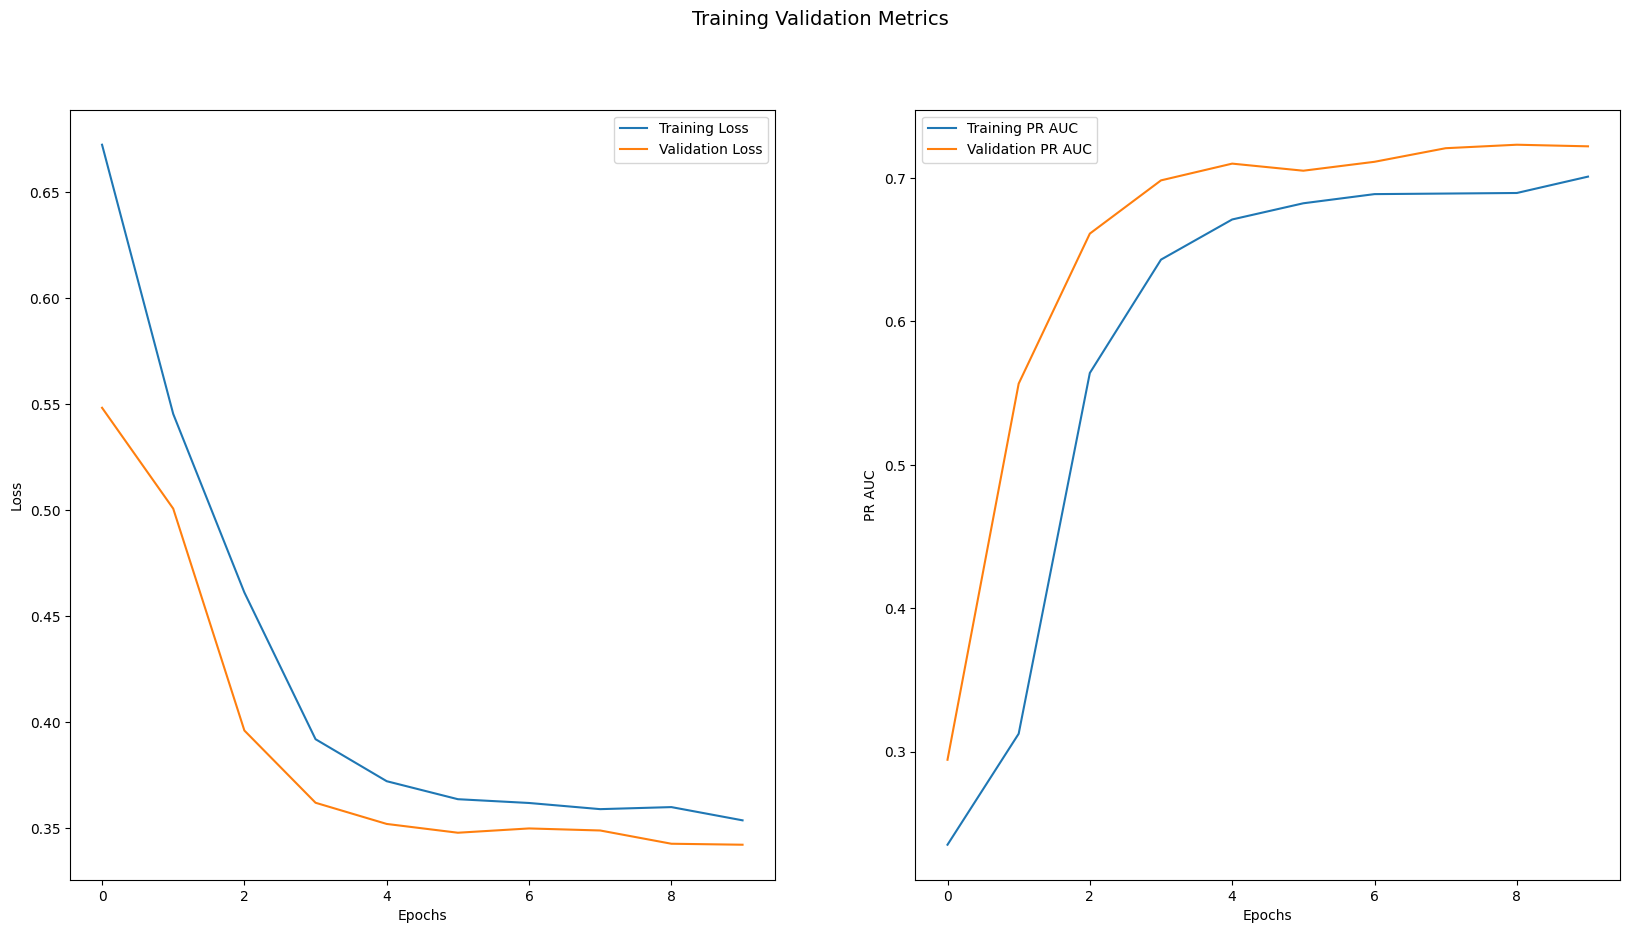

In [24]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [25]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

17/17 [==============================] - 2s 98ms/step
Test ROC AUC: 0.8881
Test PR AUC: 0.7117
Test Accuracy: 0.8404


## Explainability

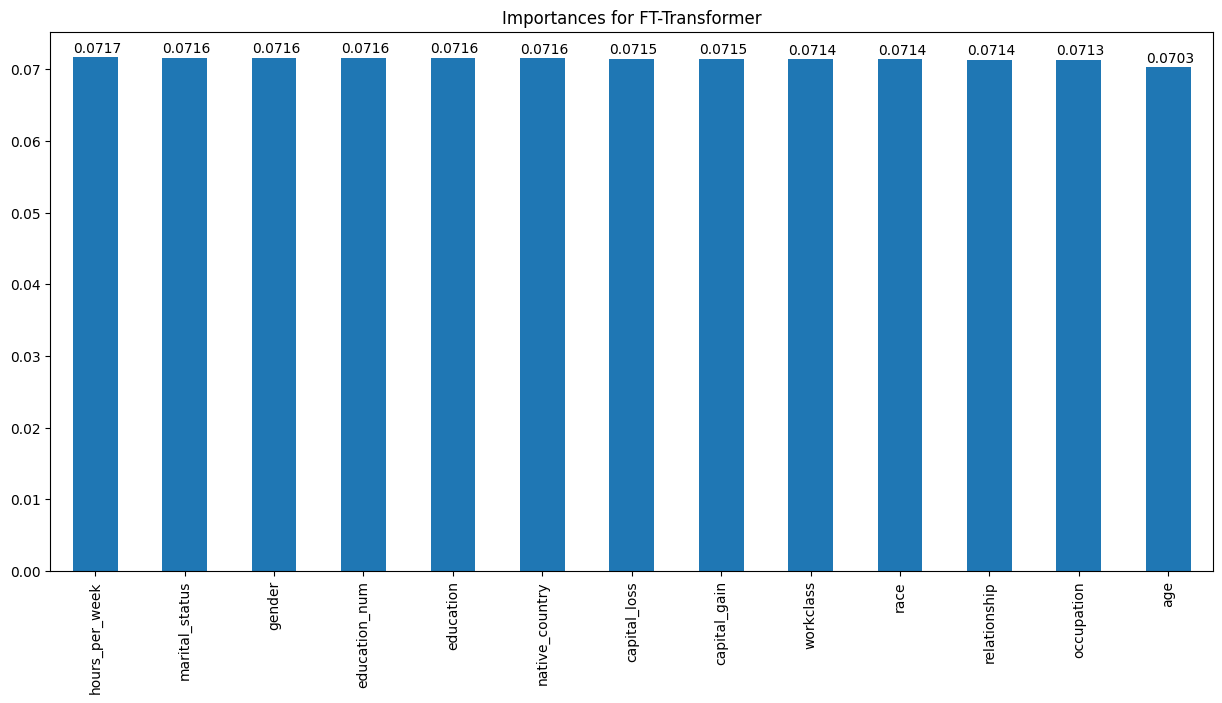

In [26]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )

In [27]:
if 'importances' in preds.keys():
    # Largest prediction
    max_idx = np.argsort(preds['output'].ravel())[-1]
    example_importance_linear = importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[max_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(preds['output'].ravel()[max_idx], 4))}")
    display(example_importance_linear)

    # Smallest one
    min_idx = np.argsort(preds['output'].ravel())[0]
    example_importance_linear = importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[min_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(preds['output'].ravel()[min_idx], 4))}")
    display(example_importance_linear)

Top 5 contributions to row 3048 which was scored 0.8981


,Importance,Example Value
workclass,0.073381,Federal-gov
marital_status,0.072198,Married-civ-spouse
capital_loss,0.072136,0.0
native_country,0.071977,United-States
occupation,0.071624,Exec-managerial


Top 5 contributions to row 14248 which was scored 0.0123


,Importance,Example Value
capital_gain,0.075456,0.0
education,0.074280,11th
education_num,0.073221,7.0
native_country,0.073018,United-States
hours_per_week,0.072395,40.0
